In [1]:
print("Hii Aski!!")

Hii Aski!!


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
# Read in all the words
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i , s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s , i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [39]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict next character
X , Y = [] , []

for w in words:
    # print(w)

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context) , '------->' , itos[ix])
        context = context[1:] + [ix] # crop and append


X = torch.tensor(X)
Y = torch.tensor(Y)

In [40]:
X.shape , X.dtype , Y.shape , Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [75]:
# built the dataset 

def built_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict next character
    X , Y = [] , []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape , Y.shape)
    return X , Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr , Ytr = built_dataset(words[:n1])
Xdev , Ydev = built_dataset(words[n1:n2])
Xte , Yte = built_dataset(words[n2:])


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [8]:
C = torch.randn((27 , 2))

In [9]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [10]:
W1 = torch.randn((6 , 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1 , 6) @ W1 + b1)

In [12]:
h

tensor([[-0.5721, -0.9842,  0.9973,  ..., -0.4420, -0.8688,  0.5503],
        [-0.2664, -0.9607,  0.4506,  ..., -0.9632,  0.5511, -0.4391],
        [-0.7187,  0.1688,  0.9993,  ..., -0.3476, -0.9698, -0.8403],
        ...,
        [-0.6913, -0.3446,  0.1833,  ...,  0.9993, -0.8496,  0.9997],
        [-0.8327, -0.9648,  0.5293,  ...,  0.9978, -0.9163,  0.9978],
        [-0.8018,  0.9540, -0.0099,  ..., -0.8533,  0.3794, -0.6367]])

In [13]:
h.shape

torch.Size([32, 100])

In [14]:
W2 = torch.randn((100 , 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([32, 27])

In [17]:
counts = logits.exp()


In [18]:
prob = counts / counts.sum(1 , keepdims=True)

In [20]:
prob.shape

torch.Size([32, 27])

In [23]:
loss = -prob[torch.arange(32) , Y].log().mean()
loss

tensor(15.1932)

# --------------------- now made respactable ------------------

In [87]:
Xtr.shape , Ytr.shape # Dataset

(torch.Size([182437, 3]), torch.Size([182437]))

In [88]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27 , 2) , generator=g)
W1 = torch.randn((6 , 300) , generator=g)
b1 = torch.randn(300 , generator=g)
W2 = torch.randn((300 , 27) , generator=g)
b2 = torch.randn(27 , generator=g)
parameters = [C , W1 ,b1 , W2 , b2]

In [89]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [90]:
for p in parameters:
    p.requires_grad = True

In [91]:
# lre = torch.linspace(-3 , 0 , 1000)
# lrs = 10**lre


In [85]:
# lri = []
# lossi = []
for i in range(3000):
    # minibatch construct
    ix = torch.randint(0 , Xtr.shape[0] , (32 , ))
    
    # Forward Pass
    emb = C[Xtr[ix]] # [32 , 3 , 2] 
    h = torch.tanh(emb.view(-1 , 6) @ W1 + b1) # [32 , 100]
    logits = h @ W2 + b2 # [32 , 27]
    # counts = logits.exp()
    # prob = counts / counts.sum(1 , keepdims = True)
    # loss = -prob[torch.arange(32) , Y].log().mean()
    loss = F.cross_entropy(logits , Ytr[ix])
    # print(loss.item())

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    # lr = lrs[i]
    lr = 10**-2
    for p in parameters:
        p.data += -lr * p.grad
    
    # # Track Stats
    # lri.append(lr)
    # lossi.append(loss.item())

print(loss.item())

2.2351837158203125


In [86]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1 , 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits , Ydev)
loss

tensor(2.4863, grad_fn=<NllLossBackward0>)

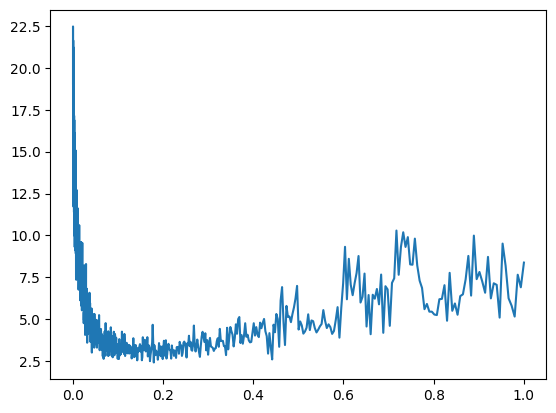

In [71]:
# plt.plot(lri , lossi)